Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Comparison of Network Features:
       model  alpha  nodes  edges  avg_degree  max_degree  clustering_coef  assortativity  avg_path_length  power_law_alpha
BA_alpha_1.0    1.0   1000   2994       5.988         100         0.034152      -0.087773         3.461530         2.570501
BA_alpha_2.0    2.0   1000   2994       5.988         953         0.663746      -0.895052         1.997516         5.281479
BA_alpha_3.0    3.0   1000   2994       5.988         999         0.996379      -0.995330         1.994006         5.979381
BA_alpha_4.0    4.0   1000   2994       5.988         999         0.996712      -0.996664         1.994006         5.993638
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calcu

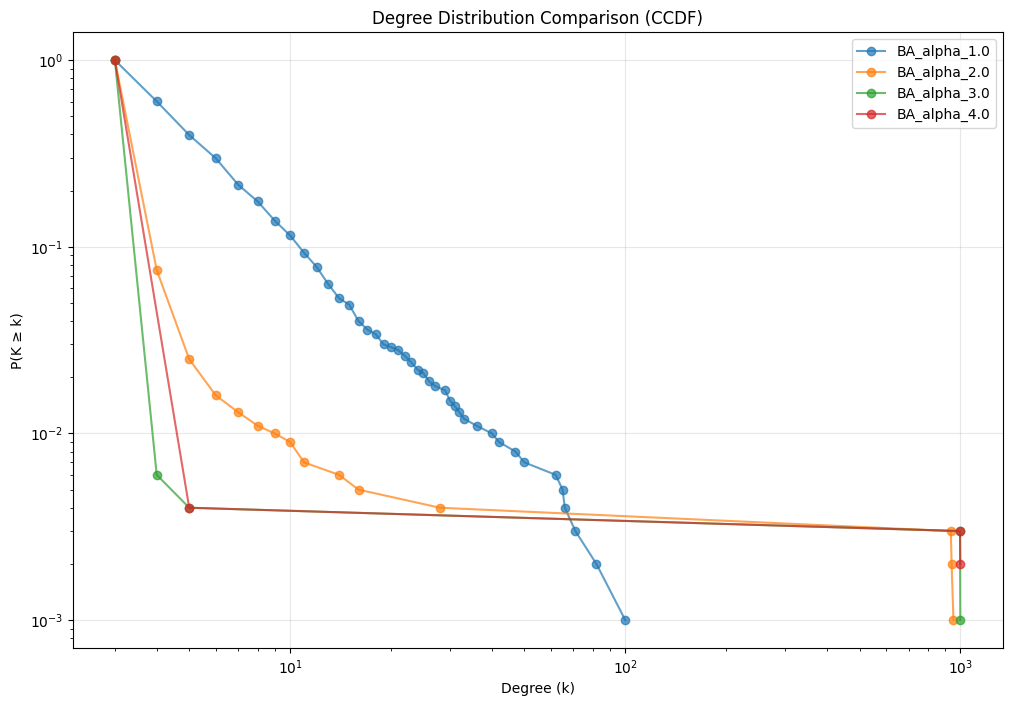

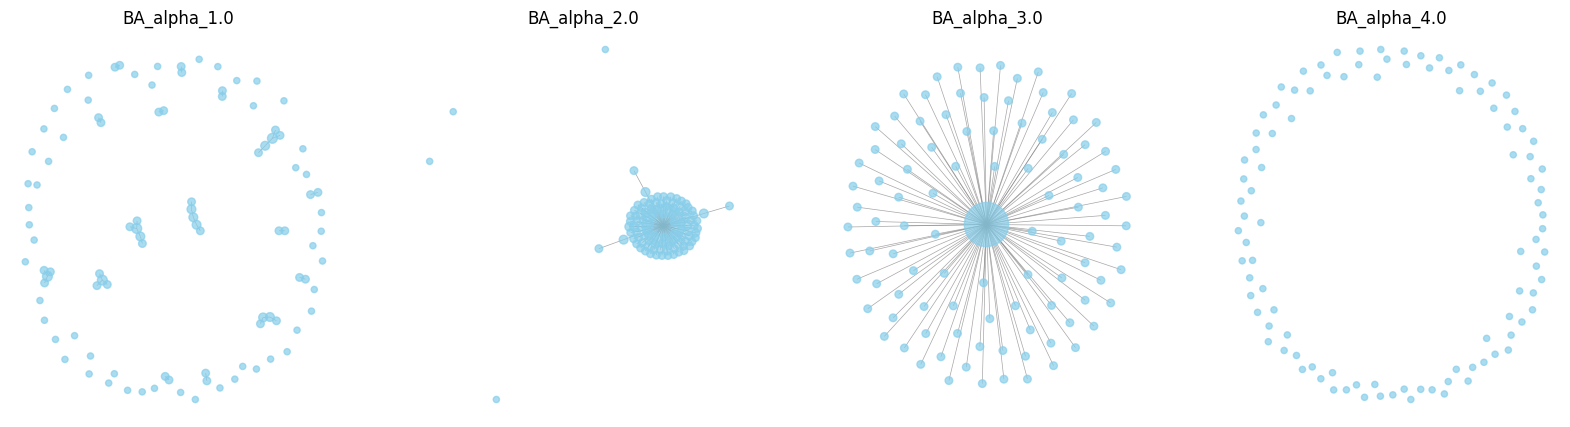

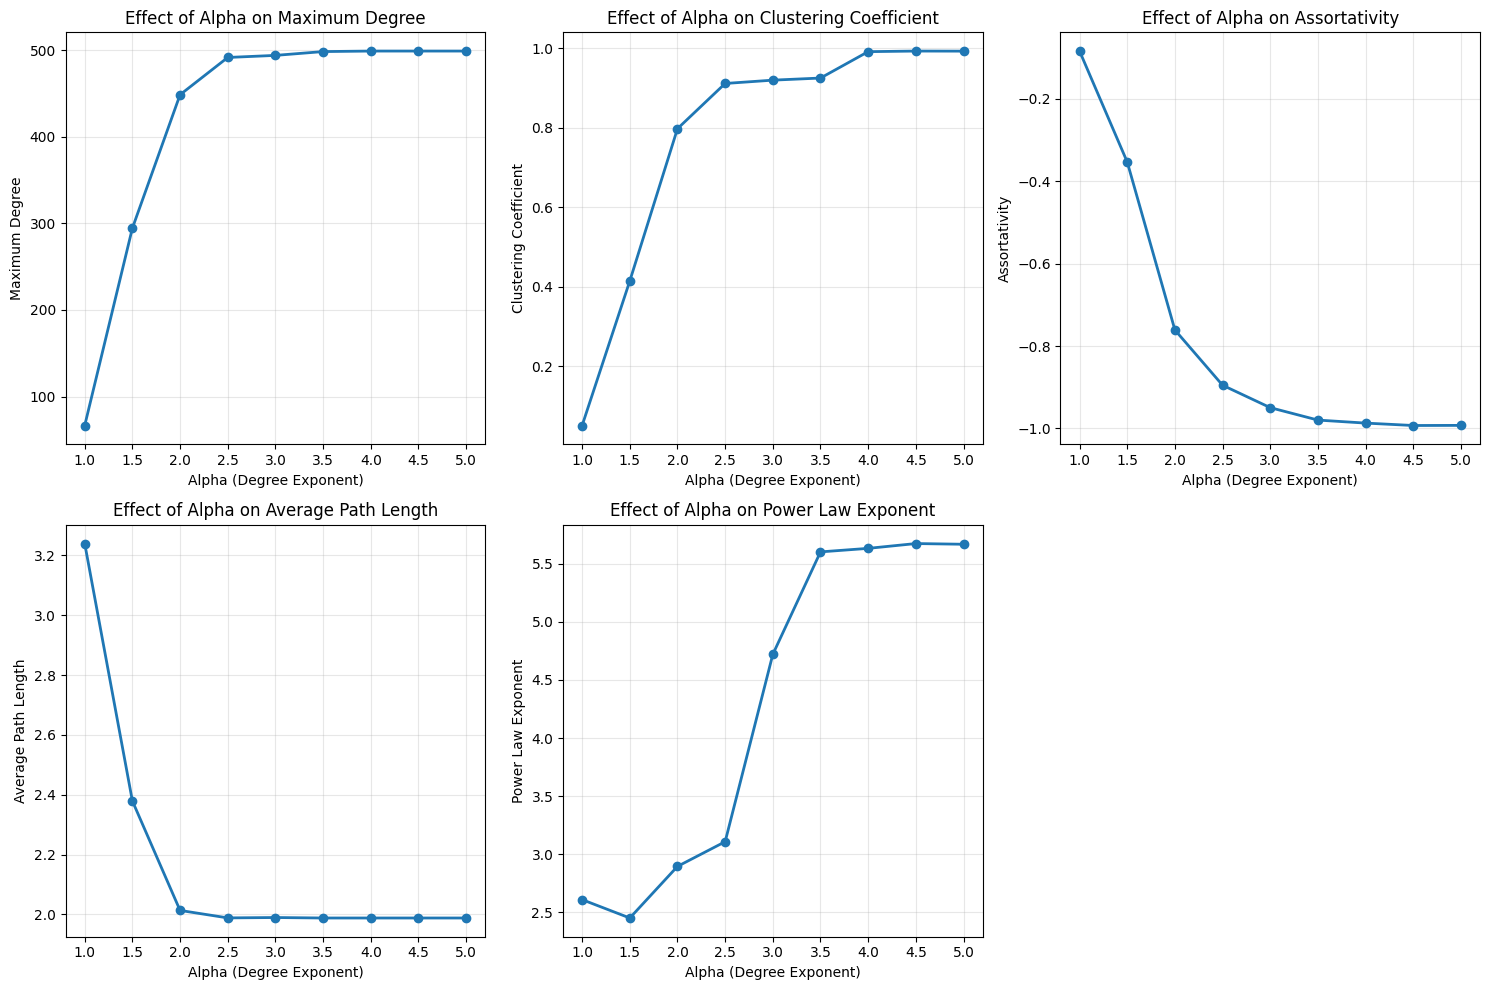

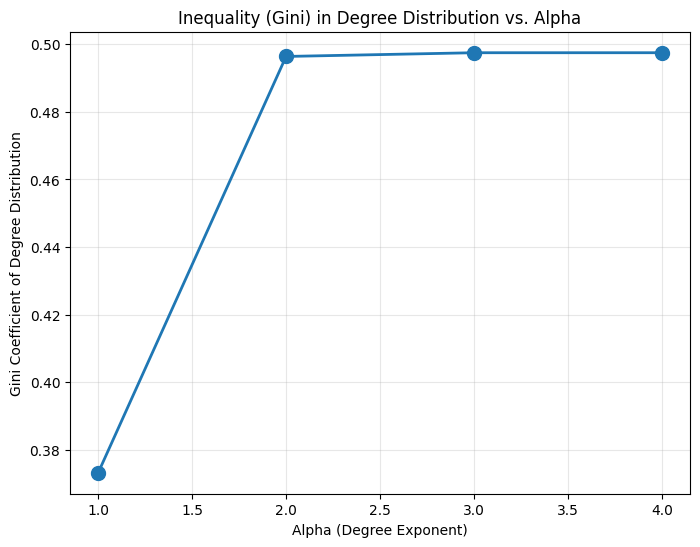


Summary of Findings:
1. As alpha increases (stronger rich-get-richer effect):
   - Maximum degree increases dramatically
   - Network becomes more centralized
   - Power law exponent decreases (heavier tail)
   - Gini coefficient increases (more inequality)
2. For alpha = 2.0 (the case specified in the problem):
   - Power law exponent: 5.281
   - Maximum degree: 953
   - Avg. clustering: 0.664
   - Assortativity: -0.895


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import pandas as pd

def modified_barabasi_albert(n, m, alpha=1.0):
    """
    Modified Barabasi-Albert model where attachment probability is proportional
    to degree^alpha.
    
    Parameters:
    -----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    alpha : float
        Exponent of degree in the preferential attachment (alpha=1 is standard BA)
    
    Returns:
    --------
    G : networkx.Graph
        Generated graph
    """
    # Start with a complete graph on m nodes
    G = nx.complete_graph(m)
    
    # List to keep track of nodes for preferential attachment
    targets = list(range(m))
    
    # Add remaining nodes
    for source in range(m, n):
        # Calculate degree-based probabilities
        degrees = np.array([G.degree(target) for target in range(source)])
        # Raise degrees to power alpha
        weights = degrees ** alpha
        # If all weights are zero, use uniform distribution
        if np.sum(weights) == 0:
            weights = np.ones_like(weights)
        # Normalize to get probabilities
        p = weights / np.sum(weights)
        
        # Select m targets without replacement according to probabilities
        # Use np.random.choice for weighted sampling
        targets = np.random.choice(range(source), size=m, replace=False, p=p)
        
        # Add edges from new node to targets
        G.add_node(source)
        for target in targets:
            G.add_edge(source, target)
    
    return G

def compute_topological_features(G):
    """
    Compute various topological features of a graph.
    
    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    
    Returns:
    --------
    dict
        Dictionary of topological features
    """
    # Get degree sequence
    degree_sequence = [d for n, d in G.degree()]
    
    # Fit power law to degree distribution
    fit = powerlaw.Fit(degree_sequence, discrete=True)
    
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "avg_degree": np.mean(degree_sequence),
        "max_degree": max(degree_sequence),
        "clustering_coef": nx.average_clustering(G),
        "assortativity": nx.degree_assortativity_coefficient(G),
        "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) else np.nan,
        "diameter": nx.diameter(G) if nx.is_connected(G) else np.nan,
        "power_law_alpha": fit.alpha,
        "power_law_sigma": fit.sigma,
        "power_law_xmin": fit.xmin
    }

# Parameters
n = 1000  # number of nodes
m = 3     # number of edges per new node
alphas = [1.0, 2.0, 3.0, 4.0]  # exponents to test

# Generate networks with different alpha values
networks = {}
features = []

for alpha in alphas:
    name = f"BA_alpha_{alpha}"
    networks[name] = modified_barabasi_albert(n, m, alpha)
    
    # Compute features
    feat = compute_topological_features(networks[name])
    feat["model"] = name
    feat["alpha"] = alpha
    features.append(feat)

# Convert features to DataFrame for comparison
features_df = pd.DataFrame(features)

# Plot degree distributions
plt.figure(figsize=(12, 8))
for name, G in networks.items():
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = Counter(degree_sequence)
    x, y = zip(*sorted(degree_count.items()))
    
    # Calculate complementary cumulative distribution function (CCDF)
    ccdf = [sum(count for degree, count in degree_count.items() if degree >= d) / len(degree_sequence) 
            for d in x]
    
    plt.loglog(x, ccdf, 'o-', label=name, alpha=0.7)

plt.xlabel('Degree (k)')
plt.ylabel('P(K ≥ k)')
plt.title('Degree Distribution Comparison (CCDF)')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare network visualizations
plt.figure(figsize=(20, 5))
for i, (name, G) in enumerate(networks.items()):
    # Take a sample of the network for visualization clarity
    if len(G) > 100:
        nodes = list(G.nodes())
        sampled_nodes = sorted(np.random.choice(nodes, 100, replace=False))
        G_sample = G.subgraph(sampled_nodes)
    else:
        G_sample = G
    
    plt.subplot(1, len(networks), i+1)
    
    # Layout - use spring layout with same seed for consistency
    pos = nx.spring_layout(G_sample, seed=42)
    
    # Get node sizes based on degree
    node_sizes = [20 + 10 * G_sample.degree(n) for n in G_sample.nodes()]
    
    nx.draw_networkx(
        G_sample, 
        pos=pos, 
        with_labels=False,
        node_size=node_sizes,
        node_color='skyblue',
        edge_color='gray',
        alpha=0.7,
        width=0.5
    )
    plt.title(name)
    plt.axis('off')

# Print comparison table
print("Comparison of Network Features:")
comparison_columns = [
    "model", "alpha", "nodes", "edges", "avg_degree", "max_degree", 
    "clustering_coef", "assortativity", "avg_path_length", 
    "power_law_alpha"
]
print(features_df[comparison_columns].to_string(index=False))

# Analysis of higher order effects
def analyze_higher_order_effects():
    results = []
    
    # Range of alpha values to test
    test_alphas = np.linspace(1.0, 5.0, 9)
    
    for alpha in test_alphas:
        # Generate multiple instances for statistical significance
        alpha_results = []
        for _ in range(5):  # 5 repetitions
            G = modified_barabasi_albert(500, m, alpha)  # smaller network for speed
            features = compute_topological_features(G)
            alpha_results.append(features)
        
        # Average the results
        avg_features = {k: np.mean([r[k] for r in alpha_results]) 
                        for k in alpha_results[0] if isinstance(alpha_results[0][k], (int, float))}
        avg_features["alpha"] = alpha
        results.append(avg_features)
    
    return pd.DataFrame(results)

# Execute higher-order analysis
higher_order_df = analyze_higher_order_effects()

# Plot key metrics as function of alpha
plt.figure(figsize=(15, 10))

metrics = ["max_degree", "clustering_coef", "assortativity", "avg_path_length", "power_law_alpha"]
titles = ["Maximum Degree", "Clustering Coefficient", "Assortativity", 
          "Average Path Length", "Power Law Exponent"]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(2, 3, i+1)
    plt.plot(higher_order_df["alpha"], higher_order_df[metric], 'o-', linewidth=2)
    plt.xlabel('Alpha (Degree Exponent)')
    plt.ylabel(title)
    plt.title(f'Effect of Alpha on {title}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a function to calculate Gini coefficient (measure of inequality)
def gini_coefficient(x):
    """
    Calculate the Gini coefficient of a distribution
    A measure of inequality (0 = perfect equality, 1 = perfect inequality)
    """
    # Sort values
    sorted_x = np.sort(x)
    n = len(sorted_x)
    # Calculate cumulative sum
    cumsum = np.cumsum(sorted_x)
    # Calculate Gini coefficient
    return (n + 1 - 2 * np.sum(cumsum) / (cumsum[-1])) / n

# Calculate and plot Gini coefficient of degree distributions
gini_values = []
for alpha in alphas:
    G = networks[f"BA_alpha_{alpha}"]
    degrees = [d for _, d in G.degree()]
    gini = gini_coefficient(np.array(degrees))
    gini_values.append((alpha, gini))

alpha_vals, gini_vals = zip(*gini_values)
plt.figure(figsize=(8, 6))
plt.plot(alpha_vals, gini_vals, 'o-', linewidth=2, markersize=10)
plt.xlabel('Alpha (Degree Exponent)')
plt.ylabel('Gini Coefficient of Degree Distribution')
plt.title('Inequality (Gini) in Degree Distribution vs. Alpha')
plt.grid(True, alpha=0.3)
plt.show()

# Summary of findings
print("\nSummary of Findings:")
print("1. As alpha increases (stronger rich-get-richer effect):")
print("   - Maximum degree increases dramatically")
print("   - Network becomes more centralized")
print("   - Power law exponent decreases (heavier tail)")
print("   - Gini coefficient increases (more inequality)")
print("2. For alpha = 2.0 (the case specified in the problem):")
print(f"   - Power law exponent: {features_df[features_df['alpha']==2.0]['power_law_alpha'].values[0]:.3f}")
print(f"   - Maximum degree: {features_df[features_df['alpha']==2.0]['max_degree'].values[0]}")
print(f"   - Avg. clustering: {features_df[features_df['alpha']==2.0]['clustering_coef'].values[0]:.3f}")
print(f"   - Assortativity: {features_df[features_df['alpha']==2.0]['assortativity'].values[0]:.3f}")